# Ridge & Lasso Regression with Housing Data

We will be using a small dataset will try predict the target variable using basic linear regression, ridge regression and Lasso. First, we import the library functions we need.

In [1]:
# import all the required libraries and put matplotlib in inline mode to plot on the notebook
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import model_selection
%matplotlib inline

We define the usual utility functions to compute the value of the polynomial given x, to generate the variables used for polynomial approximation and to plot the resulting approximation.

In [2]:
def compute_polynomial_model(x, coef, intercept):
    """Compute the polynomial given the input x, the intercept and the coefficients"""
    min_x = min(x)
    max_x = max(x)
    xp = np.arange(min_x, max_x, (max_x-min_x)/100.0)

    x = xp
    yp = intercept

    for w in coef:
        yp = yp + w * x
        x = x * xp
    return xp,yp

def generate_variables(original_column, degree):
    """Generates the list of variables for a polynomial approximator"""
    v = [original_column]
    for d in range(2,degree+1):
        v.append(original_column+str(d))
    return v

def add_degrees(dataset,original_column, degree):
    """Given a column name and the degree of a polynomial, it adds 
    all the extra columns needed for a polynomial approximator"""
    
    new_dataset = dataset
    current_column = original_column
    for d in range(2,degree+1):
        column_name = original_column+str(d)

        new_dataset[column_name] = new_dataset[current_column]*dataset[original_column]

        current_column = column_name

    return new_dataset

def plot_approximator(x,y,xp,yp,title=""):
    """Plots the original data (x,y) and a set of point (xp,yp) showing the model approximation"""
    font = {'family' : 'sans',
        'size'   : 14}
    plt.rc('font', **font)

    plt.scatter(x, y,  color='blue')
    plt.plot(xp, yp, color='red', linewidth=3)
    plt.xlabel("x")
    plt.ylabel("y")
    
    if (title!=""):
        plt.title(title)

    plt.show()

We load the data points and plot them.

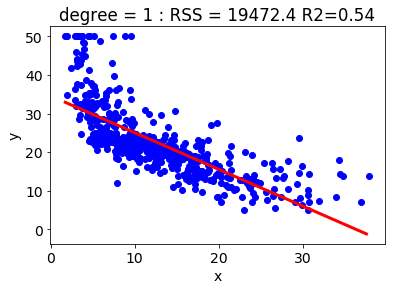

In [4]:
dataset = pd.read_csv('housing.csv')
dataset.columns
dataset.describe()

train,test = model_selection.train_test_split(dataset, test_size=0.33, random_state=1234)

# compute the data inputs
x = dataset['LSTAT'].values.reshape(len(dataset),1)

# compute the data output
y = dataset['MEDV'].values.reshape(len(dataset),1)

# apply simple linear regression to fit the data
regr = linear_model.LinearRegression()
regr.fit(x, y)

# model output for the input data
yp = regr.predict(x)

# compute the model output as a line
xm,ym = compute_polynomial_model(x[:,0],regr.coef_, regr.intercept_)

# compute rss cost
rss = sum((yp-y)*(yp-y))

# the cost as R^2
r2 = regr.score(x,y)

title = "degree = 1 : RSS = "+str(round(rss[0],1)) + " R2="+str(round(r2,2))

# plot the result
plot_approximator(x[:,0],y,xm,ym,title)

Function to compute the polynomial regression for one input variable, one output variable and a degree

In [4]:
def compute_polynomial_regression(dataset, variable, target, degree):

    extended_dataset = add_degrees(dataset, variable, degree)

    dataset_train_x = extended_dataset[generate_variables(variable,degree)].values
    dataset_train_y = extended_dataset[target].values

    x = dataset_train_x.reshape(len(dataset), degree)
    y = dataset_train_y.reshape(len(dataset), 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    yp = regr.predict(x)

    rss = sum((yp-y)*(yp-y))
    r2 = regr.score(x,y)

    # the abscissa
    xm,ym = compute_polynomial_model(x[:,0],regr.coef_[0], regr.intercept_)

    max_weight = np.amax(np.abs(np.array(regr.coef_[0],regr.intercept_[0])))
    
    return xm, ym, yp, rss[0], r2, regr




In [5]:
def compute_polynomial_regression_holdout(dataset, variable, target, degree, test_size=0.33, random_state=1234):
    '''Computes RSS and R2 statistics over the train and test set.

    test_size is the percentage of data used for testing (default is 1/3)
    random_state is the seed used for sampling the data and it is used for replicability

    '''
    
    ### Add higher degree of the target variable
    extended_dataset = add_degrees(dataset, variable, degree)

    ### Split train and test
    train_data, test_data = model_selection.train_test_split(extended_dataset, test_size=0.33, random_state=1234)

    ### select only the values that we will be use
    train_x = train_data[generate_variables(variable,degree)].values
    train_y = train_data[target].values

    test_x = test_data[generate_variables(variable,degree)].values
    test_y = test_data[target].values

    ### reshape training and testing data to fit sklearn required format
    train_x = train_x.reshape(len(train_x), degree)
    train_y = train_y.reshape(len(train_y), 1)
    test_x = test_x.reshape(len(test_y), degree)
    test_y = test_y.reshape(len(test_y), 1)

    tss_test = sum((test_y - (sum(test_y)/float(len(test_y))))**2)[0]

    regr = linear_model.LinearRegression()

    regr.fit(train_x, train_y)

    y_predicted_from_test = regr.predict(test_x)
    
    rss_test = sum( (test_y-y_predicted_from_test)*(test_y-y_predicted_from_test) )[0]

    # the abscissa
    xm,ym = compute_polynomial_model(train_x[:,0],regr.coef_[0], regr.intercept_)

    return rss_test, (1-rss_test/tss_test), xm, ym, regr

In [9]:
rss, r2, xm, ym, regr = compute_polynomial_regression_holdout(dataset,'LSTAT', 'MEDV', 1)

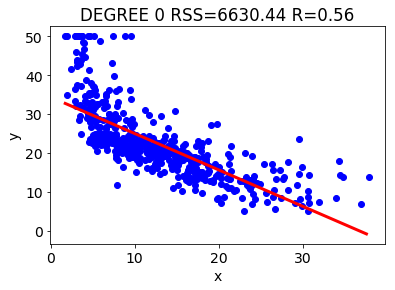

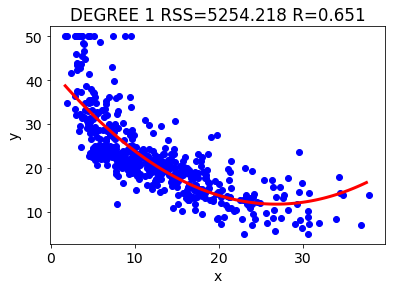

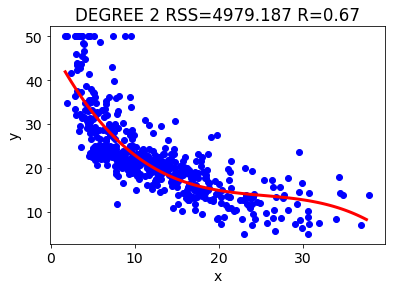

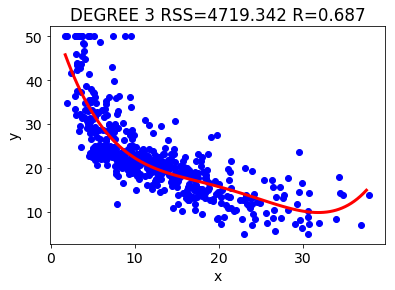

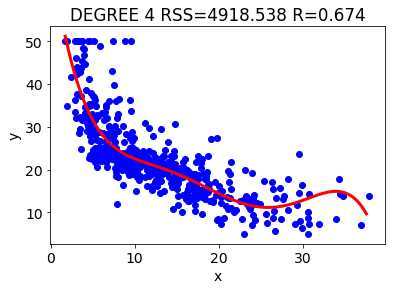

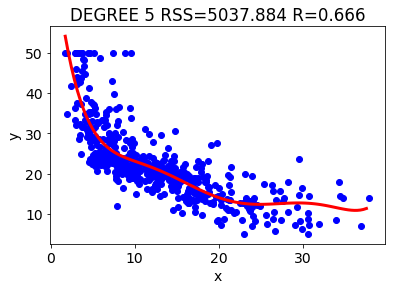

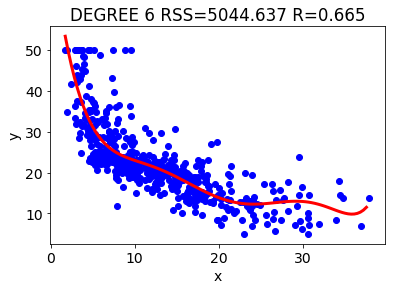

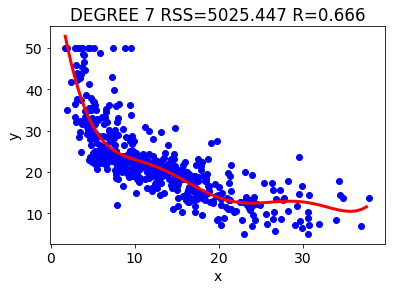

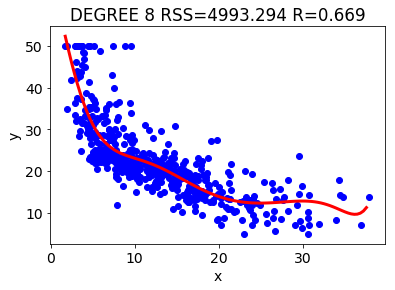

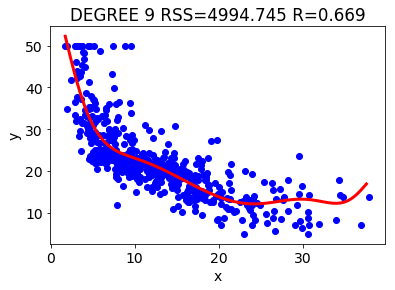

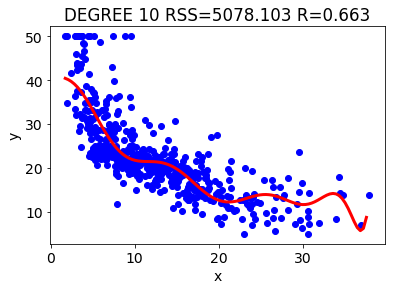

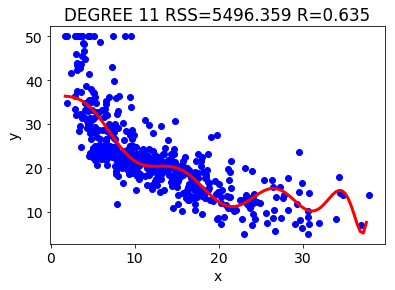

In [10]:
max_polynomial = 12
for degree in range(0,max_polynomial):
    rss, r2, xm, ym, regr = compute_polynomial_regression_holdout(dataset,'LSTAT', 'MEDV', degree+1)
    title = "DEGREE "+str(degree)+" RSS=" + str(round(rss,3))+" R="+str(round(r2,3))
    plot_approximator(dataset['LSTAT'],dataset['MEDV'],xm,ym,title)

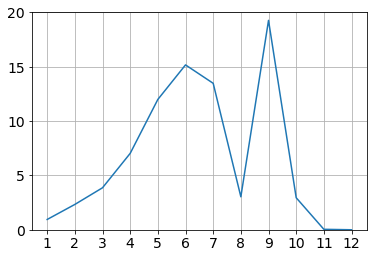

In [28]:
max_polynomial = 12

weight_sum = np.zeros(max_polynomial)

for degree in range(0,max_polynomial):
    xm, ym, yp, rss, r2, regr = compute_polynomial_regression(dataset,'LSTAT', 'MEDV', degree+1)
    weight_sum[degree] = np.amax(np.abs(np.array(regr.coef_[0])))
    
plt.plot(range(1,max_polynomial+1), weight_sum[range(0,max_polynomial)])
plt.xticks(range(1,max_polynomial+1))
plt.ylim([0,20])
plt.grid()

In [26]:
def compute_polynomial_ridge(dataset, variable, target, degree, a=1.0):

    extended_dataset = add_degrees(dataset, variable, degree)

    dataset_train_x = extended_dataset[generate_variables(variable,degree)].values
    dataset_train_y = extended_dataset[target].values

    x = dataset_train_x.reshape(len(dataset), degree)
    y = dataset_train_y.reshape(len(dataset), 1)

    regr = linear_model.Ridge(alpha=a)
    regr.fit(x, y)

    yp = regr.predict(x)

    rss = sum((yp-y)*(yp-y))
    r2 = regr.score(x,y)

    # the abscissa
    xm,ym = compute_polynomial_model(x[:,0],regr.coef_[0], regr.intercept_)

    max_weight = np.amax(np.abs(np.array(regr.coef_)))

    return xm, ym, yp, rss[0], r2, regr

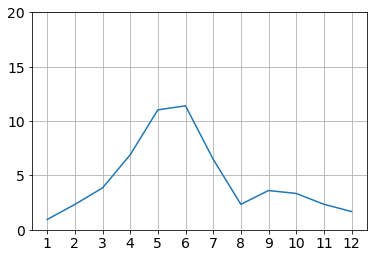

In [29]:
max_polynomial = 12

weight_sum = np.zeros(max_polynomial)

for degree in range(0,max_polynomial):
    xm, ym, yp, rss, r2, regr = compute_polynomial_ridge(dataset,'LSTAT', 'MEDV', degree+1, a=1.0)
    weight_sum[degree] = np.amax(np.abs(np.array(regr.coef_[0])))
    
plt.plot(range(1,max_polynomial+1), weight_sum[range(0,max_polynomial)])
plt.xticks(range(1,max_polynomial+1))
plt.ylim([0,20])
plt.grid()    

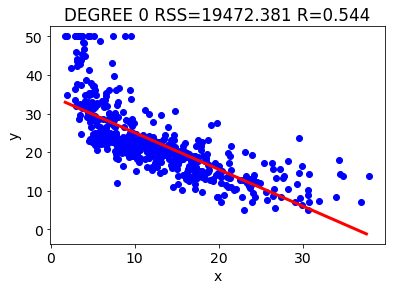

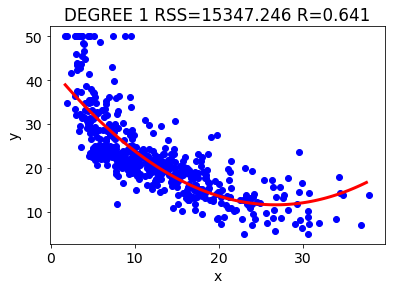

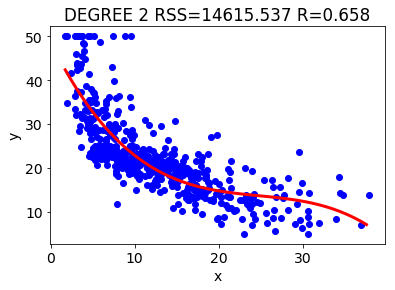

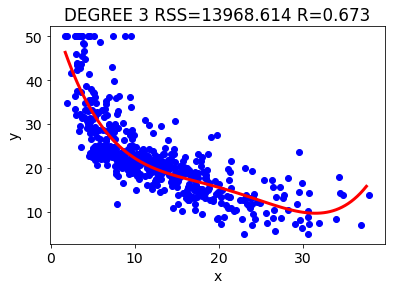

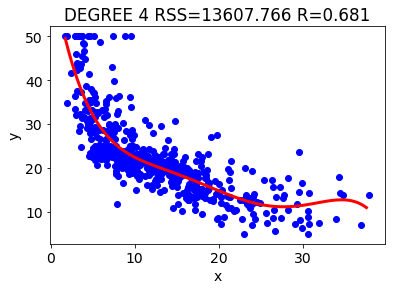

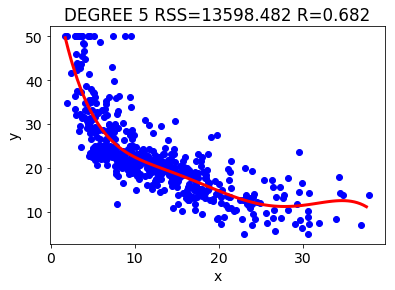

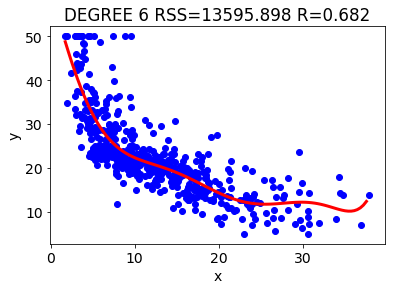

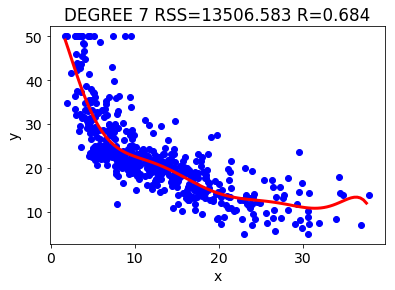

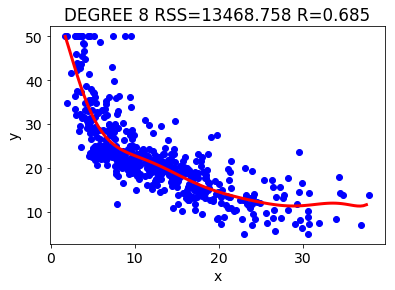

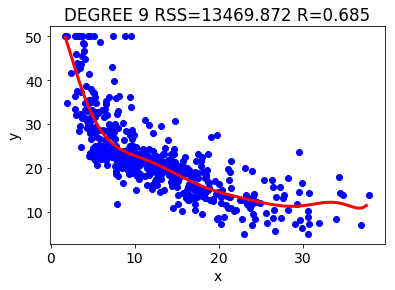

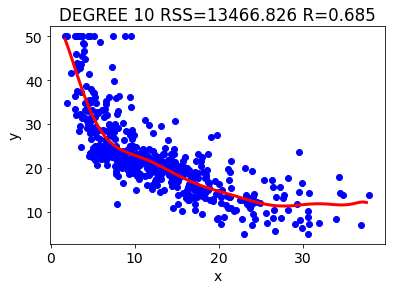

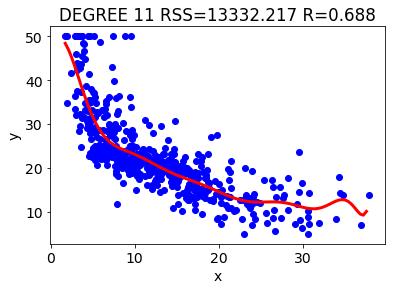

In [30]:
max_polynomial = 12
for degree in range(0,max_polynomial):
    xm, ym, yp, rss, r2, regr = compute_polynomial_ridge(dataset,'LSTAT', 'MEDV', degree+1)
    title = "DEGREE "+str(degree)+" RSS=" + str(round(rss,3))+" R="+str(round(r2,3))
    plot_approximator(dataset['LSTAT'],dataset['MEDV'],xm,ym,title)

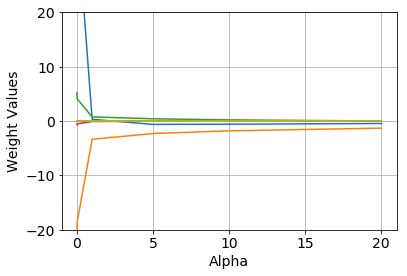

In [66]:
set_of_alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

weights = []

for alpha in set_of_alphas:
    xm, ym, yp, rss, r2, regr = compute_polynomial_ridge(dataset,'LSTAT', 'MEDV', 10, a=alpha)
    weights.append(regr.coef_[0])
                   
weight_matrix = pd.DataFrame(weights)

weight_matrix.columns = generate_variables('LSTAT',10)


plt.plot(set_of_alphas, weight_matrix['LSTAT'])
plt.plot(set_of_alphas, weight_matrix['LSTAT2'])
plt.plot(set_of_alphas, weight_matrix['LSTAT3'])
plt.plot(set_of_alphas, weight_matrix['LSTAT4'])
plt.plot(set_of_alphas, weight_matrix['LSTAT5'])
plt.plot(set_of_alphas, weight_matrix['LSTAT6'])
plt.plot(set_of_alphas, weight_matrix['LSTAT7'])
plt.plot(set_of_alphas, weight_matrix['LSTAT8'])
plt.plot(set_of_alphas, weight_matrix['LSTAT9'])
plt.ylim([-20,20])
plt.xlabel('Alpha')
plt.ylabel('Weight Values')
font = {'family' : 'sans',
    'size'   : 14}
plt.rc('font', **font)
plt.grid()

Compute an approximation using a second degree polynomial

In [86]:
def compute_polynomial_lasso(dataset, variable, target, degree, a=1.0):

    extended_dataset = add_degrees(dataset, variable, degree)

    dataset_train_x = extended_dataset[generate_variables(variable,degree)].values
    dataset_train_y = extended_dataset[target].values

    x = dataset_train_x.reshape(len(dataset), degree)
    y = dataset_train_y.reshape(len(dataset), 1)

    regr = linear_model.Lasso(alpha=a, max_iter=1e5, tol=0.01)
    regr.fit(x, y)

    yp = regr.predict(x)

    rss = sum((yp-y)*(yp-y))
    r2 = regr.score(x,y)

    #print(degree,"\t",regr.coef_)
    
    # the abscissa
    xm,ym = compute_polynomial_model(x[:,0],regr.coef_, regr.intercept_)

    max_weight = np.amax(np.abs(np.array(regr.coef_)))

    #max_weight = np.amax(np.array(regr.coef_[0])) - np.amin(np.array(regr.coef_[0]))
    
    return xm, ym, yp, rss[0], r2, regr

/Users/pierluca/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


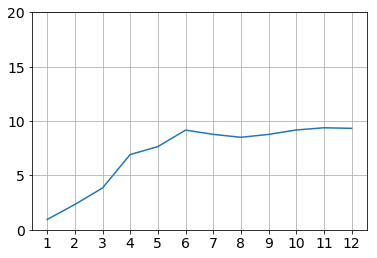

In [87]:
max_polynomial = 12

weight_sum = np.zeros(max_polynomial)

for degree in range(0,max_polynomial):
    xm, ym, yp, rss, r2, regr = compute_polynomial_lasso(dataset,'LSTAT', 'MEDV', degree+1, a=0.01)
    weight_sum[degree] = np.amax(np.abs(np.array(regr.coef_[0])))
    
plt.plot(range(1,max_polynomial+1), weight_sum[range(0,max_polynomial)])
plt.xticks(range(1,max_polynomial+1))
plt.ylim([0,20])
plt.grid()


/Users/pierluca/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Alpha  1e-15 	 [ -7.86287652e+00   6.45944881e-01  -2.74869941e-02   5.51476484e-04
  -4.04085319e-06]
Alpha  1e-10 	 [ -7.86287651e+00   6.45944881e-01  -2.74869941e-02   5.51476484e-04
  -4.04085318e-06]
Alpha  1e-08 	 [ -7.86287631e+00   6.45944853e-01  -2.74869924e-02   5.51476440e-04
  -4.04085276e-06]
Alpha  0.0001 	 [ -7.86077704e+00   6.45661721e-01  -2.74703441e-02   5.51035836e-04
  -4.03655999e-06]
Alpha  0.001 	 [ -7.84188174e+00   6.43113277e-01  -2.73204947e-02   5.47070008e-04
  -3.99792125e-06]
Alpha  0.01 	 [ -7.65292928e+00   6.17628928e-01  -2.58220059e-02   5.07411875e-04
  -3.61153548e-06]
Alpha  1 	 [ -0.00000000e+00  -4.18526000e-01   3.54432623e-02  -1.12421553e-03
   1.23877749e-05]
Alpha  5 	 [ -0.00000000e+00  -3.00102590e-01   2.22195375e-02  -6.29024118e-04
   6.33021385e-06]
Alpha  10 	 [ -0.00000000e+00  -1.45506741e-01   4.95021127e-03   1.78366384e-05
  -1.58423683e-06]
Alpha  20 	 [ -0.00000000e+00  -0.00000000e+00  -1.09977256e-02   6.06123718e-04
  -

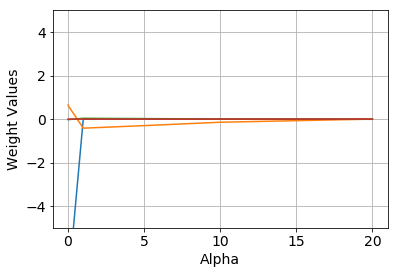

In [89]:
set_of_alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

weights = []

for alpha in set_of_alphas:
    xm, ym, yp, rss, r2, regr = compute_polynomial_lasso(dataset,'LSTAT', 'MEDV', 5, a=alpha)
    weights.append(regr.coef_)
    #print("Alpha ",alpha,"\t",regr.coef_ )
                   
weight_matrix = pd.DataFrame(weights)

weight_matrix.columns = generate_variables('LSTAT',5)


plt.plot(set_of_alphas, weight_matrix['LSTAT'])
plt.plot(set_of_alphas, weight_matrix['LSTAT2'])
plt.plot(set_of_alphas, weight_matrix['LSTAT3'])
plt.plot(set_of_alphas, weight_matrix['LSTAT4'])
plt.ylim([-5,5])
plt.xlabel('Alpha')
plt.ylabel('Weight Values')
font = {'family' : 'sans',
    'size'   : 14}
plt.rc('font', **font)
plt.grid()



## Model Evaluation using Crossvalidation

We now define a function that given the input and output variables and the degree of the target polynomial compute the model score using 10-fold cross validation.

In [215]:
from sklearn.model_selection import cross_val_score

def compute_polynomial_lasso_cv(dataset, variable, target, degree, a=1.0):

    extended_dataset = add_degrees(dataset, variable, degree)

    dataset_train_x = extended_dataset[generate_variables(variable,degree)].values
    dataset_train_y = extended_dataset[target].values

    x = dataset_train_x.reshape(len(extended_dataset), degree)
    y = dataset_train_y.reshape(len(extended_dataset), 1)

    tss = sum((y - (sum(y)/float(len(y))))**2)[0]


    regr = linear_model.Lasso(alpha=a, max_iter=100, tol=0.01, copy_X=True, normalize=False, positive=False, precompute=False)
    #scores = cross_val_score(regr, x, y, cv=10)


    #rss = (1 - scores)*tss

    #return (sum(scores)/10.0), (sum(rss)/10.0)

    return 0, 0

Let's score the models up to the 15th degree polynomial

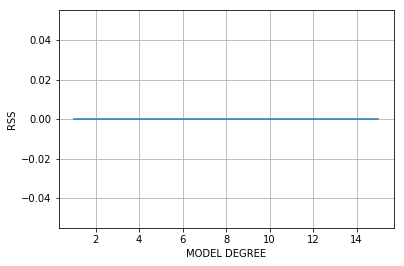

In [216]:
max_polynomial = 15
rss = np.zeros(max_polynomial)
r2 = np.zeros(max_polynomial)

for i in range(max_polynomial):
    r2[i],rss[i] = compute_polynomial_lasso_cv(dataset,'x','y',i+1, a=0.01)

plt.xlabel("MODEL DEGREE")
plt.ylabel("RSS")
plt.grid()
    
plt.plot(range(1,max_polynomial+1), rss)

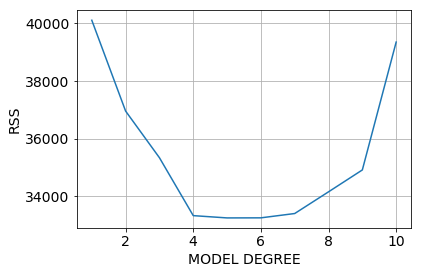

In [62]:
plt.xlabel("MODEL DEGREE")
plt.ylabel("RSS")
plt.grid()
    
plt.plot(range(1,11), rss[range(1,11)])

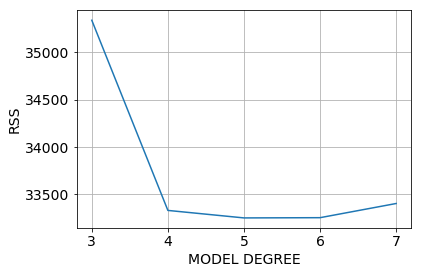

In [63]:
plt.xlabel("MODEL DEGREE")
plt.ylabel("RSS")
plt.grid()
    
plt.plot(range(3,8), rss[range(3,8)])

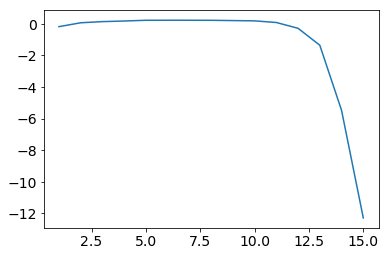

In [64]:
plt.plot(range(1,max_polynomial+1),r2)

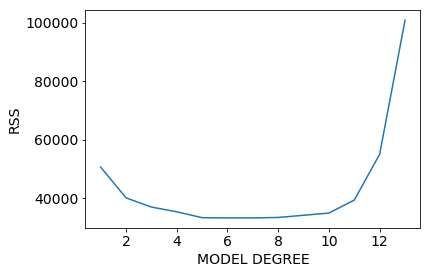

In [65]:
plt.xlabel("MODEL DEGREE")
plt.ylabel("RSS")
plt.plot(range(1,14), rss[0:13])

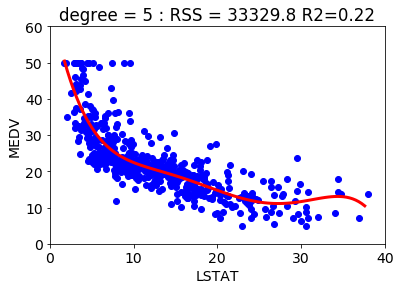

In [66]:
xm,ym,yp,rss_4,r2_5 = compute_polynomial_regression(dataset,'LSTAT', 'MEDV', 5)
title = "degree = 5 : RSS = "+str(round(rss[4],1)) + " R2="+str(round(r2[4],2))
plot_approximator(x[:,0],y,xm,ym,title)

# Using all the variables
We now build a model to predict MEDV using all the available variables.

In [81]:
dataset = pd.read_csv('housing.csv')

variables = dataset.columns.tolist()
variables.remove('MEDV')

dataset_train_x = dataset[variables].values
dataset_train_y = dataset['MEDV'].values

x = dataset_train_x.reshape(len(dataset), len(variables))
y = dataset_train_y.reshape(len(dataset), 1)

multiregr = linear_model.LinearRegression()
multiregr.fit(x, y)

yp = multiregr.predict(x)
rss = round(sum((yp-y)*(yp-y))[0],3)
scores = cross_val_score(multiregr, x, y, cv=10)
tss = sum((y - (sum(y)/float(len(y))))**2)[0]
rss_cv = sum((1 - scores)*tss)/10.0

Utility function to print the final model

In [82]:
def pretty_print(intercept, coeff, variables, target):
    """Print the model equation"""
    eq = target + " = " + str(round(intercept,2))

    for v in range(len(coeff)):
        sym = " "
        if coeff[v]>0:
            sym = " + "
        eq = eq + sym + str(round(coeff[v],2)) + variables[v]

        if (len(eq)>60):
            print(eq)
            eq = " " * (len(target + " = "))
            #eq = eq + "\n" + " "*(len(target + " = ")

    print(eq)

In [83]:
pretty_print(multiregr.intercept_[0], multiregr.coef_[0], variables, 'MEDV')
print("TRAINING RSS =",rss)
print("CROSSVALIDATION RSS =",rss_cv)

MEDV = 36.46 -0.11CRIM + 0.05ZN + 0.02INDUS + 2.69CHAS -17.77NOX
        + 3.81RM + 0.0AGE -1.48DIS + 0.31RAD -0.01TAX -0.95PTRATIO
        + 0.01B -0.52LSTAT
TRAINING RSS = 11078.785
CROSSVALIDATION RSS = 34065.0072455
